In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf

from backtesting import Backtest, Strategy
from backtesting.lib import crossover
from backtesting.test import SMA, GOOG

/opt/anaconda3/lib/python3.12/site-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

/opt/anaconda3/lib/python3.12/site-packages/backtesting/test/__init__.py:8: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.read_csv(join(dirname(__file__), filename),
/opt/anaconda3/lib/python3.12/site-packages/backtesting/test/__init__.py:8: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.read_csv(join(dirname(__file__), filename),


In [2]:
# Data Collection
ticker = 'AAPL'
stock_data = yf.download(ticker, start='2020-01-01', end='2024-01-01')
stock_data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,74.059998,75.150002,73.797501,75.087502,72.876129,135480400
2020-01-03,74.287498,75.144997,74.125000,74.357498,72.167595,146322800
2020-01-06,73.447502,74.989998,73.187500,74.949997,72.742653,118387200
2020-01-07,74.959999,75.224998,74.370003,74.597504,72.400528,108872000
2020-01-08,74.290001,76.110001,74.290001,75.797501,73.565186,132079200


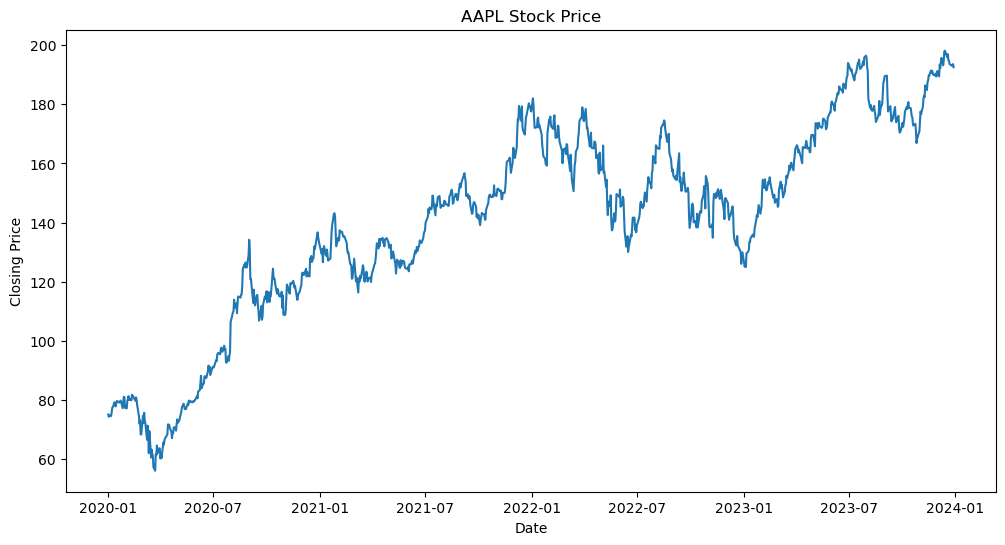

In [3]:
# Visualize Data
plt.figure(figsize=(12, 6))
plt.plot(stock_data['Close'])
plt.title(f'{ticker} Stock Price')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()

In [4]:
# Data Preprocessing
# Feature Selection
data = stock_data[['Close']]

# Scaling Data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Splitting Data
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [5]:
# Prepare Data for LSTM
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), 0])
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape data to fit LSTM input requirements
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [6]:
# Define the Model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(time_step, 1)),
    tf.keras.layers.LSTM(50, return_sequences=False),
    tf.keras.layers.Dense(25),
    tf.keras.layers.Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the Model
model.fit(X_train, y_train, batch_size=1, epochs=1)

 

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


743/743 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0070


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


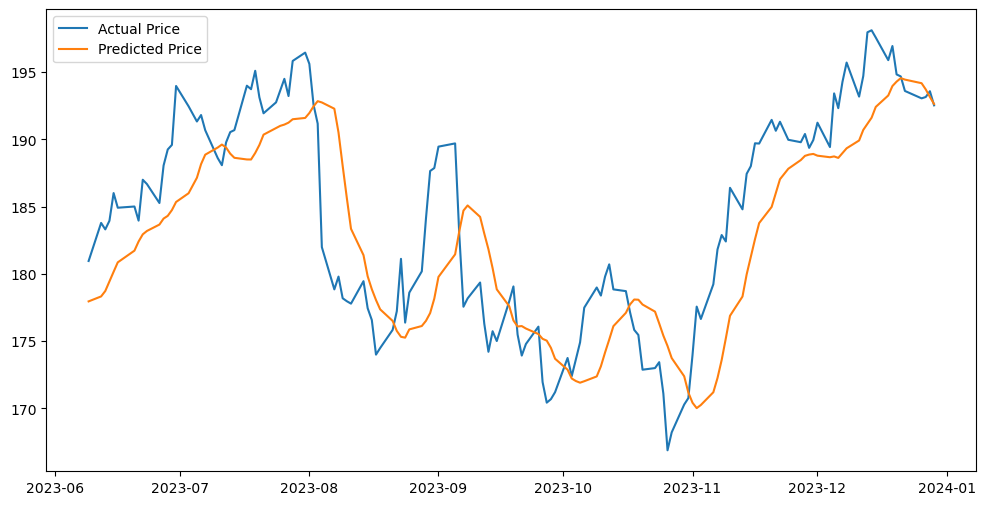

In [7]:
# Make Predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Adjust the Test Data for Plotting
adjusted_test_data = test_data[time_step + 1:]
adjusted_test_data = scaler.inverse_transform(adjusted_test_data)

# Visualize Predictions
plt.figure(figsize=(12, 6))
plt.plot(data.index[train_size + time_step + 1:], adjusted_test_data, label='Actual Price')
plt.plot(data.index[train_size + time_step + 1:], predictions, label='Predicted Price')
plt.legend()
plt.show()

In [8]:
rmse = np.sqrt(mean_squared_error(adjusted_test_data, predictions))
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 4.978040170433932


In [9]:
# Setup Backtesting Environment
class SmaCross(Strategy):
    def init(self):
        price = self.data.Close
        self.ma1 = self.I(SMA, price, 10)
        self.ma2 = self.I(SMA, price, 20)

    def next(self):
        if crossover(self.ma1, self.ma2):
            self.buy()
        elif crossover(self.ma2, self.ma1):
            self.sell()

# Apple data from yfinance
data = yf.download('AAPL', start='2015-01-01', end='2019-01-01')
bt = Backtest(data, SmaCross, commission=.002, exclusive_orders=True)
stats = bt.run()

# Plotting Results
bt.plot(filename='backtest_results.html', open_browser=True)

[*********************100%%**********************]  1 of 1 completed
/opt/anaconda3/lib/python3.12/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/opt/anaconda3/lib/python3.12/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/opt/anaconda3/lib/python3.12/site-packages/backtesting/_plotting.py:456: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample(resample_rule, label='left')
/opt/anaconda3/lib/python3.12/site-packages/backtesting/_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
/opt/anaconda3/lib/python3.12/site-packages/b

GridPlot(id='p1325', ...)

In [10]:
!pip install alpaca-trade-api


In [11]:
!pip install datetime 

In [12]:
# Setup Alpaca API for Automated Trading
import alpaca_trade_api as tradeapi
import time
import datetime
import numpy as np

ALPACA_API_KEY = "PKG65EVUMSD2XXK3UYY1"
ALPACA_SECRET_KEY = "dofUFaXpzqdWjmIyA46ktnLcFHz9Eqzv5iPYmQOn"
ALPACA_BASE_URL = "https://paper-api.alpaca.markets"

api = tradeapi.REST(ALPACA_API_KEY, ALPACA_SECRET_KEY, ALPACA_BASE_URL, api_version='v2')

def trade_live():
    ticker = 'AAPL'
    sma_short_period = 10
    sma_long_period = 20

    start_time = datetime.datetime.now()
    max_duration = datetime.timedelta(hours=1)   

    while True:
        # Check if the script has run for longer than the max duration
        if datetime.datetime.now() - start_time > max_duration:
            print("Stopping the script after 1 hour.")
            break

        print("Running live simulation loop...")

        # Fetch Latest Data
        bars = api.get_bars(ticker, '1Min', limit=sma_long_period)

        # Extract Close Prices from the Bars
        close_prices = [bar.c for bar in bars]

        # Calculate Moving Averages
        if len(close_prices) >= sma_long_period:
            sma_short = np.mean(close_prices[-sma_short_period:])
            sma_long = np.mean(close_prices[-sma_long_period:])

            # Debug information for moving averages
            print(f"SMA Short: {sma_short}, SMA Long: {sma_long}")

            # Determine Position
            try:
                current_position = api.get_position(ticker)
            except:
                current_position = None

            # Check account buying power
            buying_power = api.get_account().buying_power
            print(f"Buying Power: {buying_power}")

            # Buy Signal
            if sma_short > sma_long and current_position is None:
                qty = int(float(api.get_account().cash) // close_prices[-1])
                if qty > 0:
                    api.submit_order(
                        symbol=ticker,
                        qty=qty,
                        side='buy',
                        type='market',
                        time_in_force='gtc'
                    )
                    print(f"Bought {ticker} at {close_prices[-1]}")

            # Sell Signal
            elif sma_short < sma_long and current_position is not None:
                qty = int(current_position.qty)
                if qty > 0:
                    api.submit_order(
                        symbol=ticker,
                        qty=qty,
                        side='sell',
                        type='market',
                        time_in_force='gtc'
                    )
                    print(f"Sold {ticker} at {close_prices[-1]}")

        time.sleep(60)

trade_live()

KeyboardInterrupt: 